In [2]:
from icecream import ic


In [3]:
import gym
from gym import spaces
from gym.spaces import MultiDiscrete
import numpy as np
import cv2
import random
import time
from collections import deque

import random
import math
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.spatial
import scipy.spatial.distance as distance
from operator import itemgetter
from icecream import ic
#Start the timer
#start_time = time.time()
global DEBUG,ORDER_LIMIT_QTY
DEBUG=False
ORDER_LIMIT_QTY=False          #set ORDER_LIMIT_QTY=False to process all orders available
DRONE_LIMIT_QTY=30          #set DRONE_LIMIT_QTY=False to process all orders available

shortTermMemLen=15

def distance( r1,c1,r2,c2):
    return math.sqrt(    ( r1-r2   )**2 +  ( c1-c2  )**2     )
def atWh(r,c):
    return [index for index,(wr,wc) in enumerate(whLocs) if (r,c)==(wr,wc)]
def distToNearestWarehouse(r,c):
    return math.ceil(min([ (distance(wr,wc,r,c))  for (wr,wc) in list(whLocs)]))
def getNextDrone():   #This is the Observation
    #return drone with the minimum Destination Time
    droneNum=min(drone.items(), key=lambda k: k[1][4])[0]
    locationIndex=locations[drone[droneNum][0],drone[droneNum][1] ]
    return locationIndex ,manifestSeqNum   #droneNum,r,c,payload0,payload1...
def updateDrone5(droneNum,newTup):
    newList=list(newTup)+list(drone[droneNum][5:15])
    entry=(tuple(newList))
    drone[droneNum]=entry
def markOrderFulfilled(orderIndex):
    temp=list(orders[orderIndex])
    #index 4 is fulfillment
    temp[4]=True
    tempTup=tuple(temp)
    orders[orderIndex]=tempTup
def markOrderLoaded(orderIndex):
    temp=list(orders[orderIndex])
    #index 8 is fulfillment
    temp[8]=True
    tempTup=tuple(temp)
    orders[orderIndex]=tempTup
def decrementWarehouseQty(wh,prodNum):
    temp=list(warehouse[wh])
    #index 4 is fulfillment
    temp[whProdOffset+prodNum]-=1
    tempTup=tuple(temp)
    warehouse[wh]=tempTup
def incrementWarehouseQty(wh,prodNum):
    temp=list(warehouse[wh])
    #index 4 is fulfillment
    temp[whProdOffset+prodNum]+=1
    tempTup=tuple(temp)
    warehouse[wh]=tempTup
def loadDrone(droneNum,pn):
    temp=list(drone[droneNum][0:dronePayloadOffset])
    payload=list(drone[droneNum][dronePayloadOffset:])
    n=payload.index(None)
    payload[n]=pn
    tempTup=tuple(temp+payload)
    drone[droneNum]=tempTup    
def unloadDrone(droneNum,pn):
    temp=list(drone[droneNum][0:dronePayloadOffset])
    payload=list(drone[droneNum][dronePayloadOffset:15])
    n=payload.index(pn)
    payload[n]=None
    tempTup=tuple(temp+payload)
    drone[droneNum]=tempTup




class SnekEnv(gym.Env):

    def __init__(self):
        super(SnekEnv, self).__init__()
        self.manifestSeqNum=0
        self.macroScore=0
        self.total_reward=0
        self.droneqty=None
        self.totalOrders=None
        self.max_weight=None
        deadline=0
        self.consumeInputFile()
        self.LUDWoptions=3
        deadline=int(deadline* (self.totalOrders/9400))
        [ priorDroneCmd.update({x:3}) for x in range(30) ] 
        # Define action and observation space
        # They must be gym.spaces objects
        
        #action position 0=drone , pos 1=LUDW, pos 2=order or warehouse ,pos 4=prodNum
        print("                                            ([ #Drones,LUDW,orders,#products ])" )
        print("self.action_space = gym.spaces.MultiDiscrete([ {},{},{},{} ])".format(2,3,self.orderIndex,self.totalProductTypes) )
        #self.action_space = gym.spaces.MultiDiscrete([1,self.LUDWoptions,len(locations),self.totalProductTypes])
        self.action_space = gym.spaces.MultiDiscrete([1,self.LUDWoptions,len(locations),len(orders)])

        #self.action_space = gym.spaces.MultiDiscrete([self.droneqty,3,self.orderIndex,self.totalProductTypes])
        
        print("                                                ManSeq#,orders_Completed,#drones,Drone@Loc,PayloadWeight,priorCmd,currentCmd ])" )
        print("self.observation_space = gym.spaces.MultiDiscrete([ {},{},{},{},{},{},{} ])".format(len(orders)*5,self.orderIndex+1,self.droneqty+1,self.locationCounter+1,maxLoad+2,3,3) )

        #self.observation_space =gym.spaces.MultiDiscrete(np.array([2001,9369,31,1254,11]))
        self.observation_space =gym.spaces.MultiDiscrete([len(orders)*9+1,self.orderIndex+1,self.droneqty+1,self.locationCounter+1,maxLoad+1,int(4),int(4)])

        #self.observation_space =spaces.Discrete(2000),spaces.Discrete(9368),spaces.Discrete(30),spaces.Discrete(1253),spaces.Discrete(10)
        # Open a logfile to write observations to:
    def showStatus(self,val=None):
        if val==None:
            rangeval=range(self.droneqty)
        else:
            rangeval=range(val,val+1)
        for i in rangeval:
            print("Drone:{} ".format(i),end=' ')
            for c in range (15):
                print(drone[i][c],end=' ')
            print( "    Excess Capacity:{}".format(maxLoad-sum([prodWeight[x] for x in filter(None,drone[i][dronePayloadOffset:15]) ]))) 
            #print("")
        print("")
    def getDroneLoc(self,droneNum):
        self.droneLoc=locations[drone[droneNum][2:4]]
        return self.droneLoc
    def getPayloadItems(self,droneNum):    
        self.payloadItems=len([self.x for self.x in drone[droneNum][5:15] if self.x!=None] )#last is # of items onboard  
        return self.payloadItems
    def resetManifestSeqNum(self):
        self.manifestSeqNum=0
    def getManifestSeqNum(self):
        return self.manifestSeqNum
    def incManifestSeqNum(self):
        self.manifestSeqNum+=1
    def getMacroScore(self):
        return self.macroScore
    def incMacroScore(self):
        self.macroScore+=1
    def resetMacroScore(self):
        self.macroScore==0
    def getWhLocs(self):
        return self.whLocs
    def consumeInputFile(self):
        #global outputFile
        global prodWeight,item,warehouse,drone,orders,locations,priorDroneCmd
        global whProdOffset,dronePayloadOffset
        global gridRows,gridCols,droneQty,deadline,maxLoad
        #global manifestSeqNum
        prodWeight={}
        item={}
        warehouse={}
        whProdOffset=2
        priorDroneCmd={}
        drone={}
        dronePayloadOffset=5
        orders ={}
        locations={}
        self.locationCounter=0
        self.manifestSeqNum=0
        self.filename="busy_day.in"
        with open(self.filename) as self.fp:
            self.line = self.fp.readline()
            self.line=self.line.strip()
            self.phase = 0

            while self.line: 
                #print("Executing section {} of input file {}: {}".format(phase,filename, line.strip()))
                if self.phase==0:
                    self.rows,self.cols,self.droneqty,deadline,maxLoad=self.line.split(maxsplit=5)
                    gridRows=int(self.rows)
                    gridCols=int(self.cols)
                    droneQty=int(self.droneqty)
                    deadline=int(deadline)
                    maxLoad=int(maxLoad)
                elif self.phase==1:  ########  Simulation  parameters  ##############
                    #print(line)
                    self.minItemWeight=maxLoad   #tune this downward as items are processed
                    self.totalProductTypes=int(self.line)
                    self.line = self.fp.readline()
                    #productWeightList = line.split()  #this is a list of product weights
                    self.prods = self.line.split()  #this is a list of product weights
                    self.productWeightList=[int(self.x) for self.x in self.prods]
                    #print(productWeightList)
                    #p=[0]*(totalProductTypes+1)  #create a list of productType object names
                    for self.productNum in range(self.totalProductTypes):
                        #instantiate each product
                        #thisWeight=productWeightList[productNum]
                        prodWeight.update({self.productNum:self.productWeightList[self.productNum]})
                    self.max_weight = max(prodWeight.values())

                elif self.phase==2:   ########  Warehouse detail  ##############
                    self.whQty=int(self.line)
                    self.whDict={}
                    self.whLocs=list()
                    self.w=[0]*(self.whQty)  #create a list of warehouse object names
                    self.itemNum=0
                    for self.warehouseNum in range(self.whQty):
                        self.line = self.fp.readline()
                        self.r,self.c = self.line.split()

                        #w[warehouseNum]=Warehouse(warehouseNum,r,c)
                        locations.update({(int(self.r),int(self.c)):self.locationCounter})
                        self.locationCounter+=1
                        self.tempList=[self.r,self.c]
                        warehouse.update({self.warehouseNum:(self.r,self.c)})                               ### Warehouse ####
                        self.whLocs.append(  (int(self.r),int(self.c), self.warehouseNum) )
                        self.whDict[(self.r,self.c)]=self.warehouseNum
                        self.line = self.fp.readline()
                        for self.productQty in self.line.split():
                            self.tempList.append(self.productQty)
                        #convert everything in the list to ints
                        self.tempList=[int(self.x) for self.x in self.tempList]
                        self.whTuple=tuple(self.tempList) 
                        warehouse.update({self.warehouseNum:self.whTuple})                        
                        #Validate all products are listed in the input file
                        #if productNum+1!= totalProductTypes:
                        #    print("ERROR:  Invalid input file load for warehouse: {} productNum={}".format(warehouseNum,productNum))
                        #    break
                    #print("warehouse Locations:{}".format(whLocs))
                    #print("Locations:{}".format(locations))
                    self.row,self.col=warehouse[0][0],warehouse[0][1]
                    #print(row,col)
                    #d=list()
                    self.dest_r,self.dest_c=(self.row,self.col)
                    self.dest_time=0
                    self.payloadBaysList=[None]*10
                    
                    self.droneFieldList=[self.row,self.col,self.dest_r,self.dest_c,self.dest_time]+self.payloadBaysList
                    self.droneFieldTup=tuple(self.droneFieldList)
                    if DRONE_LIMIT_QTY!=False:
                        self.droneqty=DRONE_LIMIT_QTY
                    else:
                        self.droneqty=droneQty
                        
                    for self.i in range(self.droneqty):
                        #drone.update({self.i:self.droneFieldTup})                    ####  Drone  ####
                        drone[self.i]=(self.droneFieldTup)
                        
                    #self.showStatus()
                    
                    
                elif self.phase==3:  ########  Customer orders   ##############
                    self.totalOrders=int(self.line)
                    #DEBUG and print("There are {} total orders".format(totalOrders))
                    if ORDER_LIMIT_QTY!=False:
                        self.totalOrders=ORDER_LIMIT_QTY
                    
                    ord=list()  #create a list of order object names
                    self.orderIndex=0
                    for self.origOrderNum in range(0,self.totalOrders):

                        self.line = self.fp.readline()
                        self.r,self.c = self.line.split()
                        self.r,self.c = int(self.r),int(self.c)
                        self.orderTup=(self.r,self.c)
                        if self.orderTup not in locations.keys():               #some orders are for repeat cust, so not at new loc
                            locations.update({self.orderTup:self.locationCounter})
                            self.locationCounter+=1
                        self.line = self.fp.readline()
                        self.orderQty = int(self.line)
                        #ord[orderNum]=Order(orderNum,r,c)
                        self.line = self.fp.readline()
                        #orderedProducts=line.split()
                        self.prodNums = [int(self.x) for self.x in self.line.split()]
                        for self.index in range(self.orderQty):
                            #instantiate order
                            self.itemWeight=prodWeight[self.prodNums[self.index]]
                            self.fulfilled=False
                            self.loaded=False
                            self.itemIndex=None                                                                ####  Order  ####
                            self.entry={self.orderIndex:(self.r,self.c,self.itemWeight,self.orderQty,self.fulfilled,self.origOrderNum,self.prodNums[self.index],self.itemIndex,self.loaded)}   
                            orders.update( self.entry )
                            self.orderIndex+=1
                        #DEBUG and print("OrderNum {}: Cust: {},{}  Line Items:{} ".format(orderNum, r,c,orderQty,line))
                    break
                self.phase +=1
                self.line = self.fp.readline()  #read next line
                self.line=self.line.strip()
            #print("Len of Locations:{}  First={}  Last={}".format(len(locations),locations[(113,179)],locations[(157,157)] )  )
            DEBUG and print("There are {} order lines".format(self.orderIndex))
            #outputFile = open("DroneSnek.csv", "w")

        
        
    def step(self, action):
        self.actionList=list(action)
        #self.prev_actions.append(self.actionList)
        self.reward=0
        self.penalty=0
        self.bonus=0
        self.order=0
        self.nextCommand = action
        #print("NextCommand:{}, {}, {}, {}:".format(nextCommand[0],nextCommand[1],nextCommand[2],nextCommand[3] ) )
        #manifestSeqNum,microScore,macroScore,droneNum,droneLoc,payloadItems=simAction(nextCommand)    

        #result=simAction(nextCommand[0],nextCommand[1],nextCommand[2],nextCommand[3]) 
        self.droneNum=self.nextCommand[0]
        self.LUDW=self.nextCommand[1]
        self.location=self.nextCommand[2]
        self.order=self.nextCommand[3]
        self.pn=orders[self.order][6]
        
        #Get current drone details:
        DEBUG and print("Drone:{}".format(self.droneNum))
        self.dr,self.dc,self.dest_r,self.dest_c,self.dest_time=drone[self.droneNum][0:5]
        self.droneStartTime=self.dest_time
        self.droneStartingRow,self.droneStartingCol=(self.dr,self.dc)
                
        #def simAction(droneNum,LUDW,param1,pn,qty=1):  # DroneNum, L/U/D/W(1-4), (wh/orderNum/Time), prodNum, qty

        self.qty=1
        self.filledOrders=len([self.k for self.k, self.v in orders.items() if self.v[4]==True ])
        self.unfilledOrders=len([self.k for self.k, self.v in orders.items() if self.v[4]!=True ])

        #print("Len of Locations:{}  First={}  Last={}".format(len(locations),locations[(113,179)],locations[(157,157)] )  )

        self.droneLoc=locations[drone[self.droneNum][2:4]]
        #print("Drone:{}  LUDW:{} param1:{} pn:{}".format(droneNum,LUDW,param1,pn))
        #print("Number of wh:{} {}".format( len(warehouse),type (warehouse)  ))
        #If this is a load or unload function, then param1 should be less than whQty
        
        #If attempting to load or unload, must be at a warehouse
        if ( self.LUDW==0 or  self.LUDW==1) and self.location>=len(warehouse):
            self.penalty=  -4 #invalid parameter
        
        #Load: drone 'L' warehouse orderNum qty            
        elif self.LUDW==0  and ( orders[self.order][8]==True or  orders[self.order][4]==True):
            #This order is has already been loaded or previously fulfilled
            self.penalty=  -3.9 
        
        #If a wait state is requested, fields pn and qty must be 0
        #elif self.LUDW==3 and (self.pn!=0 or self.qty!=0):
        #    self.penalty= -2 #invalid command
            
        #elif self.LUDW==3 and self.param1>math.sqrt( (gridRows)**2 + (gridCols)**2 ):  #There is no(?) reason to wait longer than the diag of the game grid
        #   self.penalty=  -2#invalid command
            
        #If product is not onboard for D or U operation, then negative reward
        elif (self.LUDW==1 or self.LUDW==2) and self.pn not in drone[self.droneNum][5:15]:  #U or D
            self.penalty=  -3.5 #invalid command
            
        #If drone is trying to unload from the same location it was loaded at, then penalty
        #elif self.LUDW==1 and  warehouse[self.param1][0:2]==(self.dr,self.dc):  
        #    self.penalty=  -3.2 #invalid command
            
        #If drone is trying to unload from the same location it was loaded at, then penalty
        elif self.LUDW==1 and  priorDroneCmd[self.droneNum] ==0 and warehouse[self.location][0:2]==(self.dr,self.dc):  
            self.penalty=  -10.2 #invalid command
            
        #If Load command, make sure requested warehouse has the product in stock
        elif self.LUDW==0 and warehouse[self.location][whProdOffset+self.pn]==0:
            #Not in stock
            self.penalty=  -3.3
            
        #If Load command, make sure drone has sufficient capacity
        #currentLoad=sum([prodWeight[x] for x in drone[droneNum][dronePayloadOffset:15]])
        #excessCapacity=maxLoad-sum([prodWeight[x] for x in filter(None,drone[droneNum][dronePayloadOffset:15])])
        elif self.LUDW==0 and prodWeight[self.pn]>maxLoad-sum([prodWeight[self.x] for self.x in filter(None,drone[self.droneNum][dronePayloadOffset:15]) ]):
            #Too heavy to load
            self.penalty=  -.1
            
        #emptyPayloadBays=len([x for x in drone[droneNum][5:15] if x==None])
        elif self.LUDW==0 and len([self.x for self.x in drone[self.droneNum][5:15] if self.x==None])==0:
            #No room in the inn Max number of boxes the drone can carry is 10: articicial constraint 
            self.penalty=  -2.1
        
        #Deliver: drone 'D' orderNum prodNum qty            
        elif self.LUDW==2  and orders[self.order][4]==True:
            #This order is already fulfilled
            self.penalty=  -3.4 

        elif self.LUDW==2 and orders[self.order][8]!=True :
            #This is an attempt to deliver an order that hasn't been loaded yet 
            self.penalty=  -3.41     

        elif self.LUDW==2 and self.pn not in drone[self.droneNum][5:15]  :
            #This is an attempt to deliver an order that isn't in the current payload of the specified drone 
            self.penalty=  -3.42  			
              
        ######################################## Main Loop ###########################################    
        #self.unfilledOrders=len([self.k for self.k, self.v in order.items() if self.v[4]==False ])
        else:
            
                
            self.unfilledOrders=len([self.k for self.k, self.v in orders.items() if self.v[4]==False ])
            if self.unfilledOrders>0:

                #droneNum=min(drone.items(), key=lambda k: k[1][4])[0]
                #for droneNum in range(droneQty):    #Next drone should be drone with min destTime 
                self.score=0

                
                #If "LOAD" then fly to the warehouse and load the item
                #set destRow,DestCol to the warehouse location 
                # and destTime to the distance + 1
                if self.LUDW==0:     #droneNum,LUDW,param1,pn,qty  
                    #self.incManifestSeqNum()
                    self.wh=self.location
                    self.wr,self.wc=warehouse[self.wh][0:2]
                    self.dist=math.ceil(distance(self.dr,self.dc,self.wr,self.wc))
                    #entry=(dest_r,dest_c,wr,wc,dest_time+dist+1)
                    updateDrone5(self.droneNum,(self.dest_r,self.dest_c,self.wr,self.wc,self.dest_time+self.dist+1))
                    #Decrement product from warehouse
                    decrementWarehouseQty(self.wh,self.pn)
                    #Add product to drone
                    loadDrone(self.droneNum,self.pn)
                    #Mark order as 'loaded'
                    markOrderLoaded(self.order)
                    ##if priorDroneCmd was also a load then give a reward bonus based on the total drone load
                    if priorDroneCmd[self.droneNum] == 0:
                        #self.bonus=int((sum([prodWeight[self.x] for self.x in filter(None,drone[self.droneNum][dronePayloadOffset:15]) ])/maxLoad)*10)
                        self.bonus=.75
                    else:
                        ##    self.penalty=-(math.log(self.dist)/10)  #negative reward proportional to dist to wh for 1st item
                        ##    self.bonus=0  
                        self.bonus=.25
                    #log
                    DEBUG and print("Drone:{}  L  warehouse:{}  ProdNum:{}  Qty:{}".format(self.droneNum,self.wh,self.pn,1))
                    
                    DEBUG and print("Duration to fly to correct warehouse:{}".format(self.dist+1))
                    #prevWhlist.append(item[itemIndex][0]) #Short term memory of warehouses visited
                
                #If "UNLOAD" then fly to the warehouse and unload the item
                #set destRow,DestCol to the warehouse location 
                # and destTime to the distance + 1
                elif self.LUDW==1:     #droneNum,LUDW,param1,pn,qty  
                    #self.incManifestSeqNum()
                    self.wh=self.location
                    self.wr,self.wc=warehouse[self.wh][:2]
                    self.dist=math.ceil(distance(self.dr,self.dc,self.wr,self.wc))
                    updateDrone5(self.droneNum,(self.dest_r,self.dest_c,self.wr,self.wc,self.dest_time+self.dist+1))
                    #Increment product at warehouse
                    incrementWarehouseQty(self.wh,self.pn)
                    #Remove product from drone
                    unloadDrone(self.droneNum,self.pn)
                    #If warehouse had less than 2 of these items then bonus
                    if warehouse[self.wh][whProdOffset+self.pn]<2:
                        self.bonus=10
                    #if priorDroneCmd was also an unload then give no penalty
                    elif priorDroneCmd[self.droneNum] == 1 or self.dist==0:
                        self.bonus=.66
                    else:
                        self.bonus=(1/math.log(self.dist))
                    #self.reward=-self.dist
                    #self.reward=0
                    #log
                    DEBUG and print("Drone:{}  U  warehouse:{}  ProdNum:{}  Qty:{}".format(self.droneNum,self.wh,self.pn,1))
                    
                    DEBUG and print("Duration to fly to correct warehouse:{}".format(self.dist+1))
                    #prevWhlist.append(item[itemIndex][0]) #Short term memory of warehouses visited
                    

                #If "DELIVER" then fly to the customer and deliver the item
                #set destRow,DestCol to the Order location 
                # and destTime to the distance + 1
                elif self.LUDW==2:     #droneNum,LUDW,orderNum,pn,qty  
                    #self.incManifestSeqNum()
                    self.orderIndex=self.order
                    self.cr,self.cc=orders[self.orderIndex][0],orders[self.orderIndex][1]
                    self.dist=math.ceil(distance(self.dr,self.dc,self.cr,self.cc))
                    self.newDestTime=self.dest_time+self.dist+1
                    updateDrone5(self.droneNum,(self.dest_r,self.dest_c,self.cr,self.cc,self.newDestTime))
                    self.filledOrders=len([self.k for self.k, self.v in orders.items() if self.v[4]==True ])
                    self.unfilledOrders=len([self.k for self.k, self.v in orders.items() if self.v[4]==False ])
                    #Mark order as fulfilled
                    markOrderFulfilled(self.orderIndex)
                    #Remove product from drone
                    unloadDrone(self.droneNum,self.pn)
                    #order[orderIndex][4]==True
                    #score
                    self.reward= ( ( ((deadline-self.newDestTime)/deadline) *100 ) ) 
                    #ic(self.orderIndex,self.cr,self.cc,self.dist,self.reward)

                    self.total_reward+=self.reward
                    #log
                    DEBUG and print("Drone:{}  D  Order:{}  ProdNum:{}  Qty:{}".format(self.droneNum,self.orderIndex,self.pn,1))
                    
                    DEBUG and print("Duration to fly to customer:{}".format(self.dist+1))
                    
                elif self.LUDW==3:    #Waiting  param1=duration
                    #manifestSeqNum+=1 
                    #self.incManifestSeqNum()                    
                    updateDrone5(self.droneNum,(self.dr,self.dc,self.dest_r,self.dest_c,self.dest_time+self.location))

                    #score
                    self.reward= 0
                    #log
                    DEBUG and print("Drone:{}  Wait  Duration:{}  ".format(self.droneNum,self.location))
                    
                else:
                    print("Invalid option: action(droneNum:{},LUDW:{},location:{},order:{},qty:{}".format(self.droneNum,self.LUDW,self.location,self.order,self.qty))
                    raise SystemExit("Stop right there!") 
        self.droneLoc=locations[drone[self.droneNum][2:4]]    
                
        #result=outputFile.write( str(manifestSeqNum)+","+str(microScore)+","+str(filledOrders)+","+str(droneNum)+","+str(droneLoc)+","+str(drone[droneNum][5:15]) +'\n')
        #No longer needed
        #self.payloadItems=  len([self.x for self.x in drone[self.droneNum][5:15] if self.x!=None] )#last is # of items onboard  
            
        
        #print("manifestSeqNum:{},microScore:{},macroScore:{},droneNum:{},droneLoc:{},payloadItems:{}".format(manifestSeqNum,microScore,macroScore,droneNum,droneLoc,payloadItems))
        
        #self.total_reward =len([self.k for self.k, self.v in order.items() if self.v[4]!=False ])
        if self.penalty<0:
            self.reward=self.penalty
        elif self.bonus>0: #Value 1-10 are the bonus for 
            self.reward=self.bonus
        #elif self.reward>0:
        #    self.reward=self.total_reward
        
        self.prev_reward = self.total_reward

        info = {}
        
        self.incManifestSeqNum()
        
        #if 5>self.getManifestSeqNum()>0:
        #    print("Hit manifest seq number of {}".format(self.getManifestSeqNum()))
        #if self.getManifestSeqNum()>=len(order)*9:
        if self.getManifestSeqNum()>=len(orders)*9:
            self.filledOrders=len([self.k for self.k, self.v in orders.items() if self.v[4]==True ])
            self.unfilledOrders=len([self.k for self.k, self.v in orders.items() if self.v[4]==False ])
            self.other=len([self.k for self.k, self.v in orders.items() if self.v[4]!=False and self.v[4]!=True])
            print("Hit manifest seq number limit of {} Ending episode with {} successful deliveries".format(self.getManifestSeqNum(),self.filledOrders))
            #ic(self.filledOrders,self.unfilledOrders,self.other)
            self.done=True 
        self.currentPayload=sum([prodWeight[x] for x in filter(None,drone[self.droneNum][dronePayloadOffset:15]) ])
        #if self.filledOrders/len(orders)>.80:
        #    print("80% of orders completed! ({}) in {} manifest steps".format(self.filledOrders,self.getManifestSeqNum()))
        #    self.done=True 
        if self.unfilledOrders==0:
            print("All orders completed! ({}) in {} manifest steps".format(self.filledOrders,self.getManifestSeqNum()))
            self.done=True 

        # create observation:
        #observation = [manifestSeqNum,macroScore,droneNum,droneLoc,payloadItems] + list(self.prev_actions)
        observation = [self.getManifestSeqNum(),self.filledOrders,self.droneNum,self.droneLoc,self.currentPayload,priorDroneCmd[self.droneNum],self.LUDW] 
        observation = np.array(observation)
        #print("Observation:{}   shape:{}".format( observation,observation.shape))
                #Store the prior LUDW command for later use (but only if successful)
        if self.reward>=0:
            priorDroneCmd[self.droneNum] = self.LUDW
            
        return observation, self.reward, self.done, info

    def reset(self):
        self.consumeInputFile()
        #self.resetManifestSeqNum=0
        #self.resetMacroScore()
        self.total_reward=0
        self.prev_reward = 0
        self.filledOrders = 0
        self.droneNum=0
        self.droneLoc=0
        self.currentPayload=0
        [ priorDroneCmd.update({x:3}) for x in range(30) ]
        droneNum=0
        
        self.done = False

        #self.prev_actions = deque(maxlen = shortTermMemLen)  # however long we aspire the snake to be
        #for i in range(shortTermMemLen):
        #    self.prev_actions.append(-1) # to create history

        # create observation:
        #observation = [manifestSeqNum,macroScore,droneNum,droneLoc,payloadItems] + list(self.prev_actions)
        observation = [self.getManifestSeqNum(),self.filledOrders,self.droneNum,self.droneLoc,self.currentPayload,0,0] 

        #observation = [self.getManifestSeqNum(),self.getMacroScore(),droneNum,self.getDroneLoc(droneNum),self.getPayloadItems(droneNum)] 
        observation = np.array(observation)

        return observation
    

In [4]:
env = SnekEnv()
env.reset()
#[ 10   0   4 252]  
#[ 10   2  49 252]


                                            ([ #Drones,LUDW,orders,#products ])
self.action_space = gym.spaces.MultiDiscrete([ 2,3,9368,400 ])
                                                ManSeq#,orders_Completed,#drones,Drone@Loc,PayloadWeight,priorCmd,currentCmd ])
self.observation_space = gym.spaces.MultiDiscrete([ 46840,9369,31,1254,202,3,3 ])


array([0, 0, 0, 0, 0, 0, 0])

In [79]:
#create df from locations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = {'row': [],'col': [],'locType': [],'size':[]}
df = pd.DataFrame(data)
counter=0
for i in locations.keys():
    #r,c=i[0],i[1]
    if counter<10:
        df.loc[len(df.index)] = [i[0],i[1],0,50]
    else:
        df.loc[len(df.index)] = [i[0],i[1],1,0]
    counter+=1

In [86]:
#Read submission file and alter df cols for delivered items

def checkLine(actionLine):
    line=actionLine.split()
    droneNum=int(line[0])
    param1=int(line[2] )  
    if line[1]!='W':
        param2=int(line[3] )
    if line[1]=='L':
        LUDW=0
        print("Drone:{} Load at Wh:{}  pn:{}  (Order:{}) ".format(droneNum,param1,param2,None))
        
    elif line[1]=='U':
        LUDW=1
        print("Drone:{} Unload at Wh:{}  pn:{}  ".format(droneNum,param1,param2))

    elif line[1]=='D': 
        LUDW=2
        print("Drone:{} Deliver Order:{} of pn:{}  ".format(droneNum,param1,param2))
        r,c=orders[param1][:2]
        
        df.loc[(df['row'] == r) & (df['col'] == c), 'locType'] = 2
        df.loc[(df['row'] == r) & (df['col'] == c), 'size'] = 25
        
    else:
        LUDW=3
        print("Drone:{} Wait {}   ".format(droneNum,param1))
        return None,None,None,None
    action=(droneNum,LUDW,param1,param2)
    result=env.step(action)
    return result

env = SnekEnv()
env.reset()
#checkLine("0 D 2 38 1")
filename="submission2.csv"
i=0
with open(filename) as fp:  
    line = fp.readline()
    totalLines=int(line)
    print("There are {} lines in the submission file".format(totalLines))
    
    while line and i<totalLines:
        line = fp.readline()
        #print("<{}>".format(line))
        result,score,done,_=checkLine(line)
        if score!=None and score <=0:
            print("ERROR!!  Seq: {}   Score:{}  {}".format(i,score,result))
        print(result)
        i+=1

fp.close()

                                            ([ #Drones,LUDW,orders,#products ])
self.action_space = gym.spaces.MultiDiscrete([ 2,3,9368,400 ])
                                                ManSeq#,orders_Completed,#drones,Drone@Loc,PayloadWeight,priorCmd,currentCmd ])
self.observation_space = gym.spaces.MultiDiscrete([ 46840,9369,31,1254,202,3,3 ])
There are 84 lines in the submission file
Drone:0 Load at Wh:0  pn:18  (Order:None) 
[ 1  0  0  0 40  3  0]
Drone:0 Load at Wh:0  pn:48  (Order:None) 
[  2   0   0   0 102   0   0]
Drone:0 Load at Wh:0  pn:34  (Order:None) 
[  3   0   0   0 154   0   0]
Drone:0 Deliver Order:8 of pn:48  
[ 4  0  0 18 92  0  2]
Drone:0 Load at Wh:0  pn:25  (Order:None) 
[ 5  1  0  0 96  2  0]
Drone:0 Load at Wh:0  pn:35  (Order:None) 
[  6   1   0   0 104   0   0]
Drone:0 Deliver Order:4 of pn:25  
[  7   1   0  14 100   0   2]
Drone:0 Load at Wh:0  pn:4  (Order:None) 
[  8   2   0   0 108   2   0]
Drone:0 Deliver Order:6 of pn:35  
[  9   2   0  16 100   0

<AxesSubplot:xlabel='row', ylabel='col'>

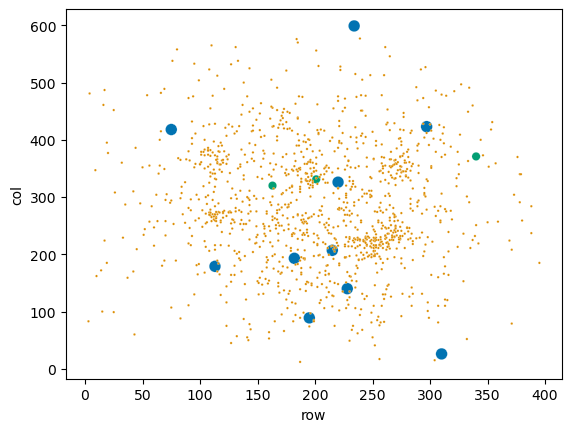

In [87]:
#scatterplot it
import numpy 
import pandas
import seaborn as sns
sns.color_palette("rocket")
sns.scatterplot(data=df, x='row', y='col', hue='locType',palette="colorblind",size='size',sizes=(3, 70),legend=False)